# Mini Reto 006 del grupo Python para Trading

# Backtrader - Estrategia basada en cruce de medias moviles simples (SMA) 


Este mini reto es la continuación natural del Mini Reto 005 donde se calcularon las medias móviles rápidas y lentas para identificar los cruces y generar una señal a partir de dichos cruces.

En esta ocasión, lo que se pide es utilizar esa experiencia previa para montar una estrategia y hacer el backtesting para evaluar los resultados de la estrategia con datos de muestra.

Lo mas sencillo, que no lo más optimo ni "real", es hacer un backtest vectorizado, dónde se añaden columnas a cada periodo indicando el beneficio/perdida en ese periodo y finalmente obtener el acumulado para saber si ha habido o no beneficio. 

Esto ya se muestra en detalle en el siguiente Webinar ( https://www.youtube.com/watch?v=CNCRGcFh5Lo ), así que vamos a dar el siguiente paso utilizando `Backtrader` para simular la estrategia lo mas "real" posible. 

Partiendo del código que hay a continuación:

- 1) Diseñar la estrategia en base a los indicadores
- 2) Configurar el entorno de backtrader
- 3) Ejecutar el backtesting con la estrategia
- 4) Analizar los resultados


**Se pide** COMPLETAR el punto 1 para hacer funcionar el Notebook al completo.

# A partir del siguiente código

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import backtrader as bt
import pyfolio as pf

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[10.5, 6]
plt.rcParams['figure.dpi']=90

import yfinance as yf

In [3]:
fast_SMA = 9
slow_SMA = 30
cash = 1000
aapl = yf.download('AAPL', '2020-1-1','2020-10-25')

[*********************100%***********************]  1 of 1 completed


# Solución propuesta

## Diseñamos la estrategia

In [4]:
class cruceSMA(bt.Strategy):
    params = dict(slow=slow_SMA,
                  fast=fast_SMA
                 )

    def __init__(self):
        fast = bt.ind.SMA(period=self.p.fast)
        slow = bt.ind.SMA(period=self.p.slow)
        self.crossover = bt.ind.CrossOver(fast, slow)

    def next(self):
        if not self.position:      # Si no hay ninguna operacion abierta
            if self.crossover > 0: # si la rapida cruza hacia arriba la lenta
                self.buy()         # Se entra en LONG
            if self.crossover < 0: # si la rapida cruza hacia abajo la lenta
                self.sell()        # Se entra en SHORT

        elif self.crossover != 0:  # Si hay una operacion abierta y el cruce es hacia abajo 
            self.close()           # Se cierra la posicion


## Configuramos el entorno

In [5]:
cerebro = bt.Cerebro()
cerebro.broker.set_cash(cash)

data = bt.feeds.PandasData(dataname=aapl)
cerebro.adddata(data)

cerebro.addstrategy(cruceSMA)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

## Ejecutamos el backtesting

<IPython.core.display.Javascript object>


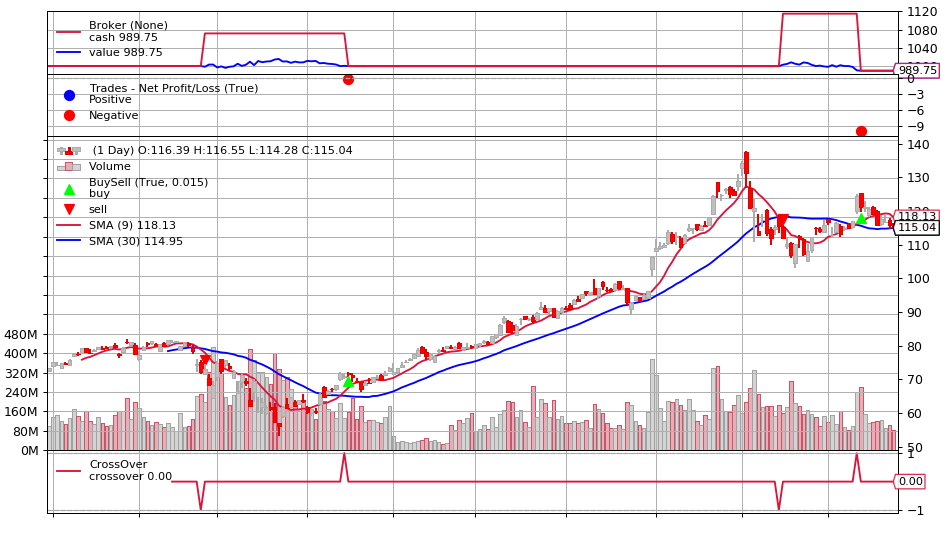

[[<Figure size 945x540 with 5 Axes>]]

In [6]:
results = cerebro.run()
#cerebro.plot(style='candlebar',iplot=False)[0][0]
cerebro.plot(style='candlebar')

## Analizamos los resultados

In [7]:
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

In [8]:
transactions

,amount,price,sid,symbol,value
date,,,,,
2020-02-26 00:00:00+00:00,-1,71.632500,0,,71.632500
2020-04-16 00:00:00+00:00,1,71.845001,0,,-71.845001
2020-09-16 00:00:00+00:00,-1,115.230003,0,,115.230003
2020-10-13 00:00:00+00:00,1,125.269997,0,,-125.269997


Start date,2019-12-31
End date,2020-10-23
Total months,9
,Backtest
Annual return,-1.2%
Cumulative returns,-1.0%
Annual volatility,2.8%
Sharpe ratio,-0.43
Calmar ratio,-0.49
Stability,0.11
Max drawdown,-2.5%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.54,2020-03-23,2020-10-13,NaT,NaN
1,0.74,2020-03-12,2020-03-13,2020-03-16,3
2,0.73,2020-02-28,2020-03-04,2020-03-09,7
3,0.48,2020-03-09,2020-03-10,2020-03-12,4
4,0.26,2020-03-16,2020-03-17,2020-03-20,5


Top 10 long positions of all time,max


Top 10 short positions of all time,max
Data0,-12.56%


Top 10 positions of all time,max
Data0,12.56%


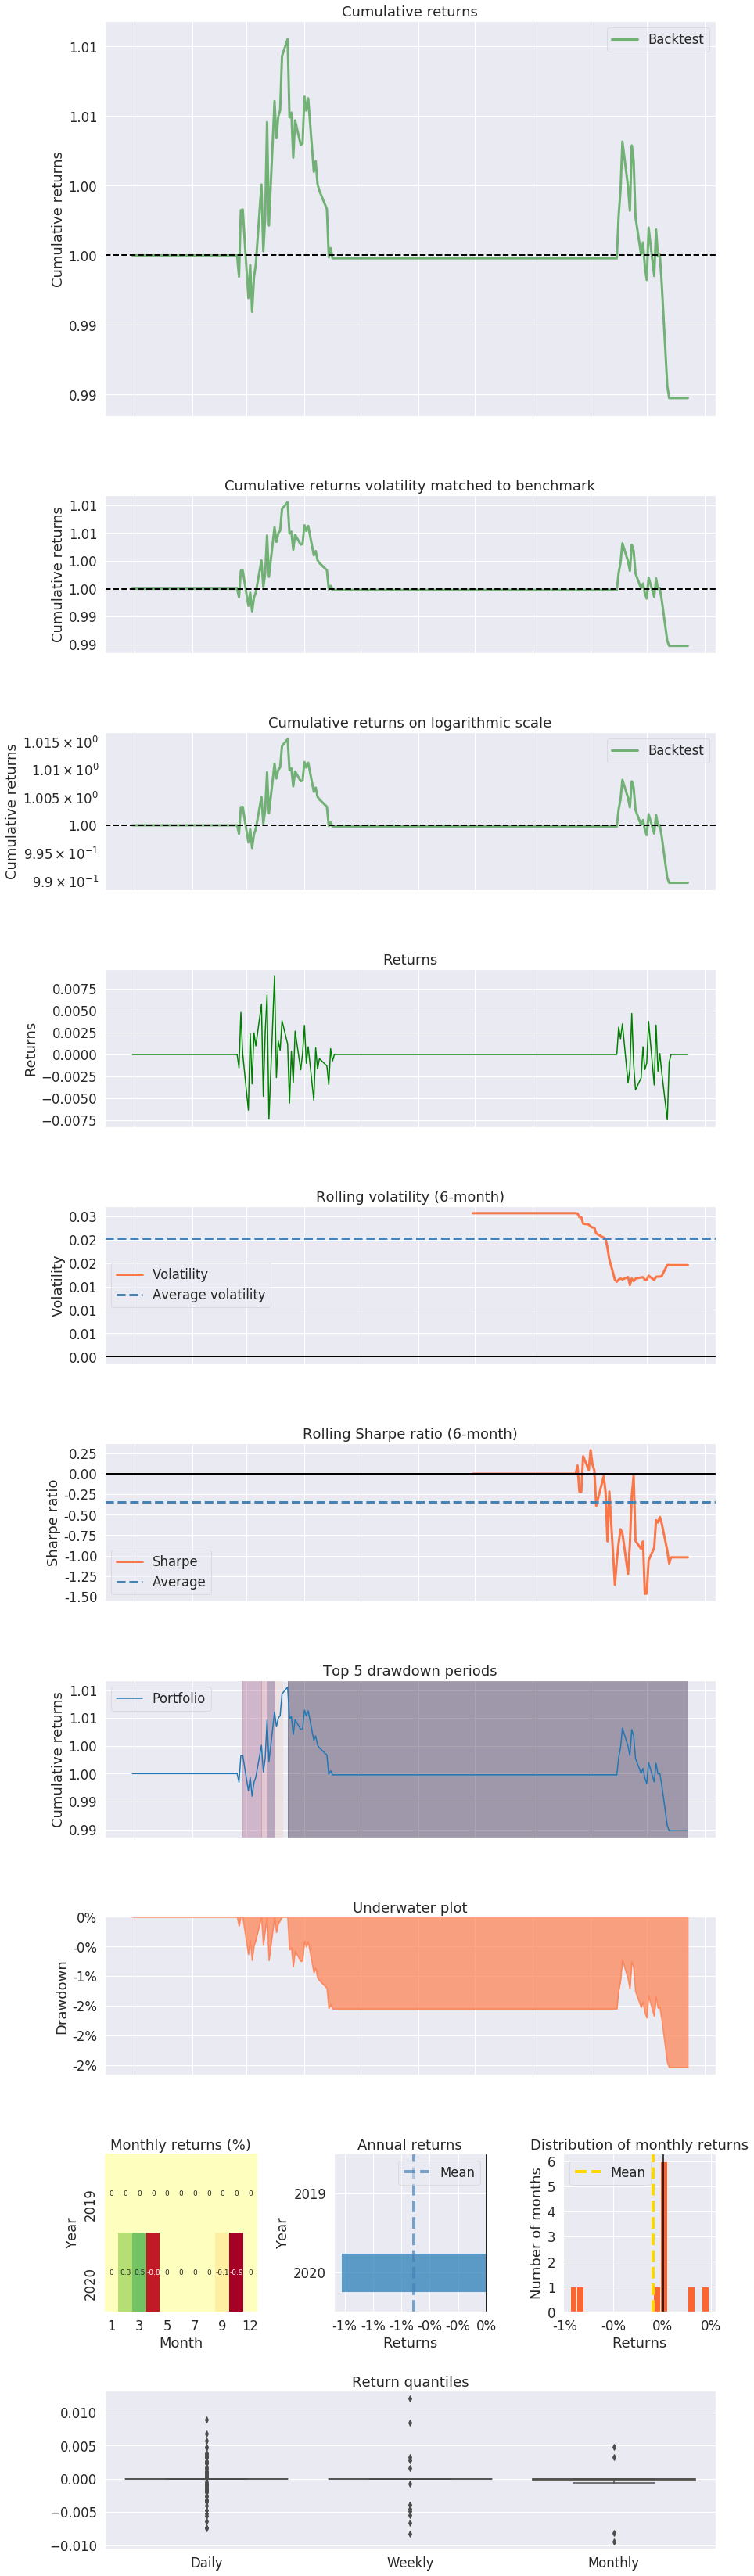

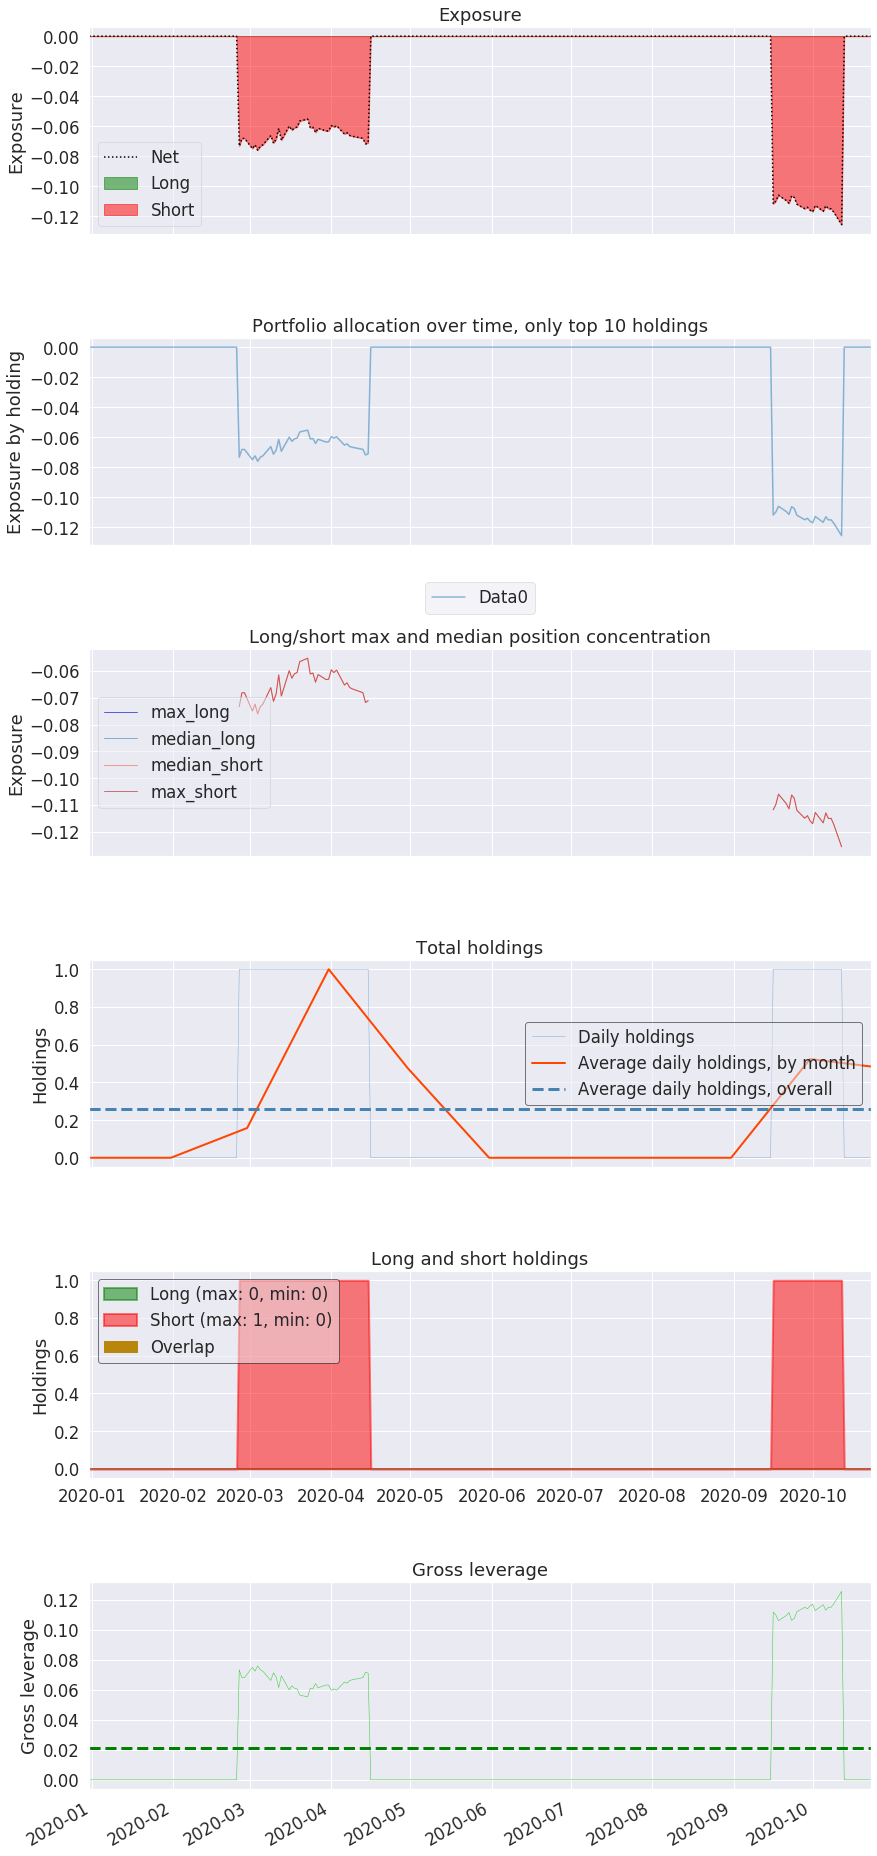

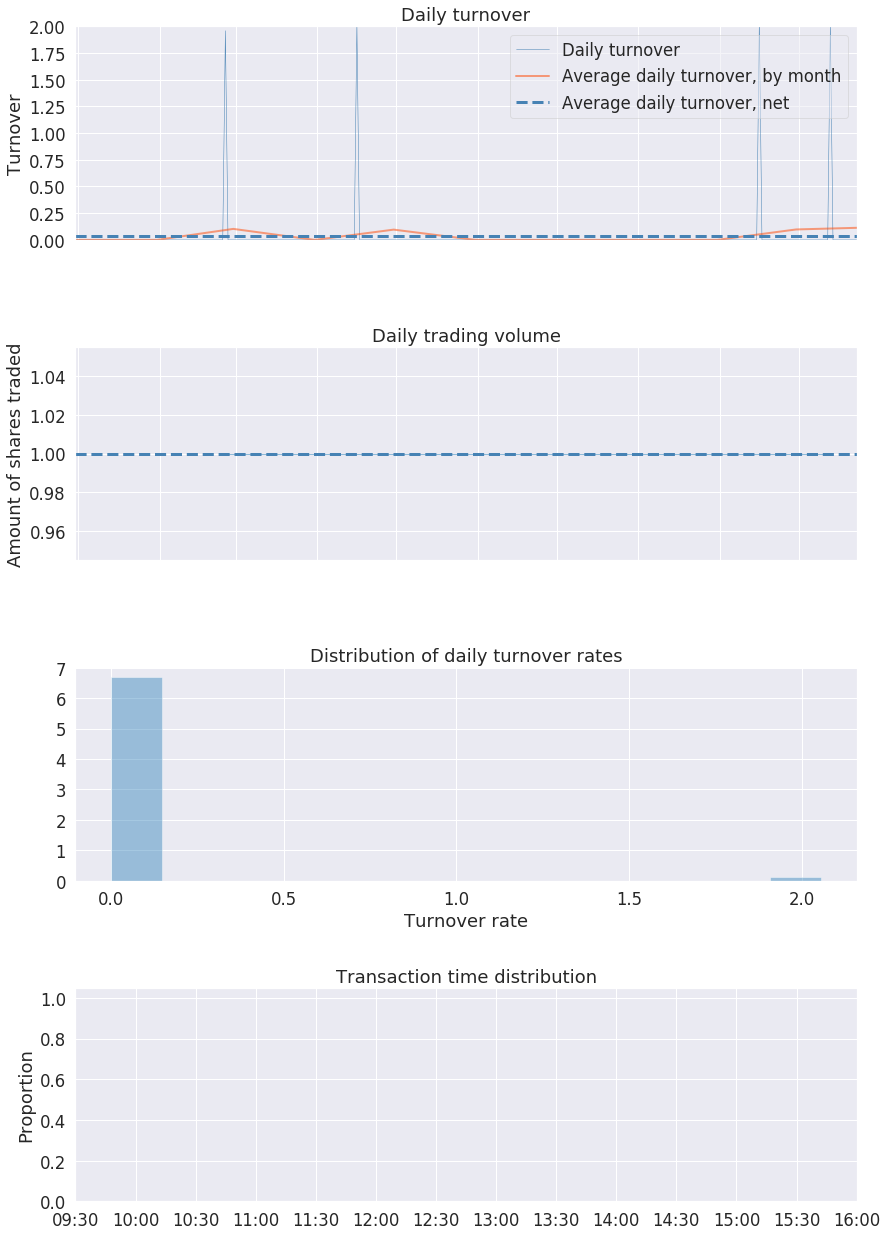

In [9]:
%matplotlib inline
pf.create_full_tear_sheet(returns, transactions=transactions, positions=positions)